In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [8]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(1, 10, 3, padding=1) #input -? OUtput? RF
        self.conv1_bn = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 15, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(15)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(15, 20, 3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(20)
        self.conv4 = nn.Conv2d(20, 30, 3, padding=1)
        self.conv4_bn = nn.BatchNorm2d(30)
        self.pool2 = nn.MaxPool2d(2,2)
        self.conv5 = nn.Conv2d(30, 35, 3)
        self.conv5_bn = nn.BatchNorm2d(35)
        self.pool3 = nn.AvgPool2d(5,5)
        #self.conv6 = nn.Conv2d(40, 40, 3)
        self.conv7 = nn.Conv2d(35, 10, 1)
        self.adder_layer1 = nn.Sequential(nn.Linear(in_features=20, out_features=60, bias=False),nn.BatchNorm1d(60),nn.ReLU(),nn.Dropout(0.1))
        self.adder_layer2 = nn.Sequential(nn.Linear(in_features=60, out_features=60, bias=False),nn.BatchNorm1d(60),nn.ReLU(),nn.Dropout(0.1))
        self.adder_layer3 = nn.Sequential(nn.Linear(in_features=60, out_features=19, bias=False))


    def forward(self, x,y):

        y = F.one_hot(y, num_classes=self.num_classes)

        x = self.pool1(self.conv2_bn(F.relu(self.conv2(self.conv1_bn(F.relu(self.conv1(x)))))))
        x = self.pool2(self.conv4_bn(F.relu(self.conv4(self.conv3_bn(F.relu(self.conv3(x)))))))
        x = self.pool3((F.relu(self.conv5(x))))

        x = self.conv7(x)

        #x = self.fc1(x)

        
        x = x.view(-1, 10)
        y = torch.cat([x, y], dim=-1)
        y = self.adder_layer1(y)
        y = self.adder_layer2(y)
        y = self.adder_layer3(y)
        
        return F.log_softmax(x),F.log_softmax(y)

In [15]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net(num_classes = 10).to(device)
#summary(model, input_size=(1, 28, 28),10)

In [10]:
from torchvision.datasets import MNIST
import numpy as np
class MyDataset(MNIST):

    def __init__(self, *args, **kwargs):
        super(MyDataset, self).__init__(*args, **kwargs)
        
    def __getitem__(self, index):
        img, target = super(self.__class__, self).__getitem__(index)
        random_number = np.random.randint(low=0, high=10)
        return (img, random_number), (target, target + random_number)

In [11]:
train_dataset = MyDataset('../data',train=True, download=True, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))
test_dataset = MyDataset('../data',train=False, download=True, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))


Extracting ../data/MyDataset/raw/train-images-idx3-ubyte.gz to ../data/MyDataset/raw




Extracting ../data/MyDataset/raw/train-labels-idx1-ubyte.gz to ../data/MyDataset/raw




Extracting ../data/MyDataset/raw/t10k-images-idx3-ubyte.gz to ../data/MyDataset/raw




Extracting ../data/MyDataset/raw/t10k-labels-idx1-ubyte.gz to ../data/MyDataset/raw

Processing...
Done!


In [12]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=batch_size, shuffle=True, **kwargs)

In [13]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        (mnist_x, rand_num) = data
        (mnist_y, final_y) = target
        mnist_x, rand_num, mnist_y, final_y  = mnist_x.to(device), rand_num.to(device), mnist_y.to(device), final_y.to(device)
        optimizer.zero_grad()
        mnist_pred, final_pred = model(mnist_x, rand_num)
        mnist_loss = F.nll_loss(mnist_pred, mnist_y)
        adder_loss = F.nll_loss(final_pred, final_y)
        loss = mnist_loss + adder_loss
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()}, MNIST_LOSS={mnist_loss.item()}, ADDER_LOSS={adder_loss.item()}, batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    mnist_correct = 0
    adder_correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            (mnist_x, rand_num) = data
            (mnist_y, final_y) = target
            mnist_x, rand_num, mnist_y, final_y  = mnist_x.to(device), rand_num.to(device), mnist_y.to(device), final_y.to(device)
            mnist_pred, final_pred = model(mnist_x, rand_num)
            mnist_loss = F.nll_loss(mnist_pred, mnist_y)
            adder_loss = F.nll_loss(final_pred, final_y)
            loss = mnist_loss + adder_loss
            mnist_pred = torch.argmax(mnist_pred, dim=1)
            final_pred = torch.argmax(final_pred, dim=1)
            test_loss += loss.item()  # sum up batch loss
            mnist_correct += mnist_pred.eq(mnist_y.view_as(mnist_pred)).sum().item()
            adder_correct += final_pred.eq(final_y.view_as(final_pred)).sum().item()


    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, MNIST_Accuracy: {}/{} ({:.2f}%), ADDER_Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, mnist_correct, len(test_loader.dataset), 100. * mnist_correct / len(test_loader.dataset), 
        adder_correct, len(test_loader.dataset), 100. * adder_correct / len(test_loader.dataset)))

In [14]:
model = Net(num_classes = 10).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.008, momentum=0.9)

for epoch in range(1, 20):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=0.9228085279464722, MNIST_LOSS=0.15539559721946716, ADDER_LOSS=0.7674129009246826, batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 31.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, MNIST_Accuracy: 9738/10000 (97.38%), ADDER_Accuracy: 8871/10000 (88.71%)



loss=0.3683478832244873, MNIST_LOSS=0.06182529032230377, ADDER_LOSS=0.3065226078033447, batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 31.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, MNIST_Accuracy: 9842/10000 (98.42%), ADDER_Accuracy: 9799/10000 (97.99%)



loss=0.19072619080543518, MNIST_LOSS=0.06298793852329254, ADDER_LOSS=0.12773825228214264, batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 31.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, MNIST_Accuracy: 9907/10000 (99.07%), ADDER_Accuracy: 9860/10000 (98.60%)



loss=0.18628942966461182, MNIST_LOSS=0.04918237030506134, ADDER_LOSS=0.13710705935955048, batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 31.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, MNIST_Accuracy: 9902/10000 (99.02%), ADDER_Accuracy: 9871/10000 (98.71%)



loss=0.10216910392045975, MNIST_LOSS=0.029455481097102165, ADDER_LOSS=0.07271362096071243, batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 31.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0006, MNIST_Accuracy: 9927/10000 (99.27%), ADDER_Accuracy: 9898/10000 (98.98%)



loss=0.15418249368667603, MNIST_LOSS=0.03572142496705055, ADDER_LOSS=0.11846106499433517, batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 31.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, MNIST_Accuracy: 9916/10000 (99.16%), ADDER_Accuracy: 9910/10000 (99.10%)



loss=0.20175334811210632, MNIST_LOSS=0.04995705559849739, ADDER_LOSS=0.15179629623889923, batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 31.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, MNIST_Accuracy: 9921/10000 (99.21%), ADDER_Accuracy: 9914/10000 (99.14%)



loss=0.13804027438163757, MNIST_LOSS=0.040742672979831696, ADDER_LOSS=0.09729760885238647, batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 31.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, MNIST_Accuracy: 9928/10000 (99.28%), ADDER_Accuracy: 9913/10000 (99.13%)



loss=0.0659157782793045, MNIST_LOSS=0.031229078769683838, ADDER_LOSS=0.03468669578433037, batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 31.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, MNIST_Accuracy: 9936/10000 (99.36%), ADDER_Accuracy: 9928/10000 (99.28%)



loss=0.21304114162921906, MNIST_LOSS=0.051194239407777786, ADDER_LOSS=0.16184690594673157, batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 31.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, MNIST_Accuracy: 9936/10000 (99.36%), ADDER_Accuracy: 9920/10000 (99.20%)



loss=0.043301261961460114, MNIST_LOSS=0.016749216243624687, ADDER_LOSS=0.026552043855190277, batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 31.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, MNIST_Accuracy: 9930/10000 (99.30%), ADDER_Accuracy: 9910/10000 (99.10%)



loss=0.12123127281665802, MNIST_LOSS=0.03288762643933296, ADDER_LOSS=0.08834365010261536, batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 31.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, MNIST_Accuracy: 9937/10000 (99.37%), ADDER_Accuracy: 9923/10000 (99.23%)



loss=0.06997786462306976, MNIST_LOSS=0.02891158126294613, ADDER_LOSS=0.041066285222768784, batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 31.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, MNIST_Accuracy: 9918/10000 (99.18%), ADDER_Accuracy: 9911/10000 (99.11%)



loss=0.029795531183481216, MNIST_LOSS=0.008843074552714825, ADDER_LOSS=0.020952455699443817, batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 30.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0005, MNIST_Accuracy: 9927/10000 (99.27%), ADDER_Accuracy: 9897/10000 (98.97%)



loss=0.02273963764309883, MNIST_LOSS=0.00952467042952776, ADDER_LOSS=0.013214967213571072, batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 30.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, MNIST_Accuracy: 9935/10000 (99.35%), ADDER_Accuracy: 9923/10000 (99.23%)



loss=0.07705450057983398, MNIST_LOSS=0.029087064787745476, ADDER_LOSS=0.04796743765473366, batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, MNIST_Accuracy: 9935/10000 (99.35%), ADDER_Accuracy: 9925/10000 (99.25%)



loss=0.049226630479097366, MNIST_LOSS=0.013281341642141342, ADDER_LOSS=0.035945288836956024, batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 29.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, MNIST_Accuracy: 9928/10000 (99.28%), ADDER_Accuracy: 9920/10000 (99.20%)



loss=0.04770108312368393, MNIST_LOSS=0.019316891208291054, ADDER_LOSS=0.028384193778038025, batch_id=468: 100%|██████████| 469/469 [00:15<00:00, 30.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, MNIST_Accuracy: 9937/10000 (99.37%), ADDER_Accuracy: 9921/10000 (99.21%)



loss=0.03612186014652252, MNIST_LOSS=0.01104610413312912, ADDER_LOSS=0.02507575787603855, batch_id=468: 100%|██████████| 469/469 [00:14<00:00, 31.37it/s]



Test set: Average loss: 0.0004, MNIST_Accuracy: 9931/10000 (99.31%), ADDER_Accuracy: 9914/10000 (99.14%)



In [16]:
def infer_and_plot_output(sample_data, model):
    (mnist_img, adder_num), (mnist_target, adder_target) = sample_data
    
    with torch.no_grad():
        mnist_pred, adder_pred = model(mnist_img, adder_num)
        mnist_pred, adder_pred = torch.argmax(mnist_pred, dim=1), torch.argmax(adder_pred, dim=1)

    num_images = 25
    fig = plt.figure(figsize=(12, 15))

    assert len(mnist_img[0] >= 25), "need atleast 25 images in `sample_data`"

    fig.suptitle('MNIST Adder')

    for idx in range(0, 25):

        image = mnist_img[idx].cpu().numpy()
        add_num = adder_num[idx].cpu().item()
        image_target = mnist_target[idx].cpu().item()
        add_target = adder_target[idx].cpu().item()
        image_pred = mnist_pred[idx].cpu().item()
        add_pred = adder_pred[idx].cpu().item()

        isvalid = (image_target == image_pred) and (add_target == add_pred)
        isvalid = str(isvalid).upper()

        ax = fig.add_subplot(5, 5, idx+1)
        ax.axis('off')
        ax.imshow(mnist_img[idx].squeeze())
        ax.set_title(f'target: {image_target} + {add_num} = {add_target}\npred: {image_pred} + {add_num} = {add_pred}\nValid: {isvalid}')

    plt.show()

In [17]:
plotting_loader = torch.utils.data.DataLoader(test_dataset, batch_size=25, shuffle=True, **kwargs)
data = iter(plotting_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


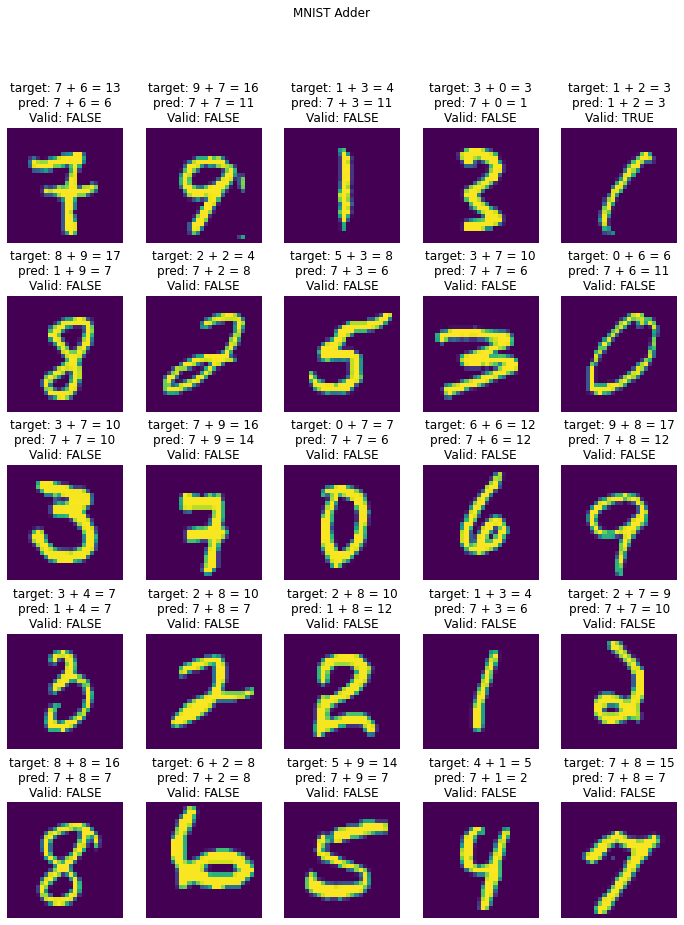

In [18]:
infer_and_plot_output(next(data),model.to('cpu'))